In [9]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
from monai.networks.nets import SwinUNETR
from monai.transforms import Transform
from monai.transforms import Compose, Flipd, Rotate90d, RandFlipd, RandRotate90d, RandSpatialCropd
import warnings
warnings.filterwarnings("ignore")
from monai.data import CacheDataset, DataLoader
import torch.nn.functional as F 
import zipfile
from tqdm import tqdm
import wandb
from datetime import datetime
### our modules
from dataset import *
from training import *
from testing import *
from preprocessing import *
from models import *
from regularization import *

# Install additional packages 
#!pip install scikit-image
#!pip install wandb
#!pip install monai==1.2.0        
#!pip install imagecodecs
#!pip install opencv-python
#!pip install einops
#!pip install pyyaml

In [10]:
# Load config
with open("configs.yaml", "r") as f:
    config = yaml.safe_load(f)
    
dataset = config["dataset_paths"][config["dataset_index"]]
if not os.path.exists(dataset):
    print("Please update your data path to an existing folder.")
elif not set(["training", "test"]).issubset(set(os.listdir(dataset))):
    print("Please update your data path to the correct folder (should contain train and test folders).")
else:
    print(f"Congrats! You selected the correct folder : {dataset}")

Congrats! You selected the correct folder : ../datasets/DRIVE_dataset/datasets/


In [11]:
## configs

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if config["device"] == "auto" else torch.device(config["device"])

# Loss function
##loss_fn = DiceLoss(sigmoid=True, batch=True) if config["loss"] == "DiceLoss" else None  # Extend as needed

batch_size = config["batch_size"]
num_workers = config["num_workers"]
n_epochs = config["n_epochs"]
ensemble_models = config["ensemble_models"]
save_path = config["save_path"]
split_ratio = config["split_ratio"]

## Dataset with Monai

In [12]:
def build_dict_vessels(data_path, mode='training'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'train' or 'test'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of images and masks.
    """
    # test if mode is correct
    if mode not in ["training", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    # list all files in directory, including the path
    paths_retina = glob.glob(os.path.join(data_path, mode, 'images', '*.tif'))
    #print(paths_retina)
        
    for retina_path in paths_retina:
        image_index = os.path.basename(retina_path).split('_')[0]
        mask_path = os.path.join(data_path, mode, '1st_manual', f'{image_index}_manual1.gif')
        padding_mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_mask.gif')

        entry = {'img': retina_path}

        # Add segmentation mask if it exists
        if os.path.exists(mask_path):
            entry['mask'] = mask_path

        # Add valid region mask (padding mask) if it exists
        if os.path.exists(padding_mask_path):
            entry['valid_mask'] = padding_mask_path

        dicts.append(entry)

    return dicts

class LoadVesselData(Transform):
    """
    This custom Monai transform loads and processes data from the rib segmentation dataset.
    It handles RGB image loading, resizing, normalization, and binary mask conversion.
    """
    def __init__(self, keys=None):
        super().__init__()
        self.keys = keys

    def __call__(self, sample):
        try:
            # Load and process the image
            image = Image.open(sample['img']).convert('L')
            image = image.resize((512, 512), resample=Image.Resampling.NEAREST)
            image = np.array(image, dtype=np.float32) / 255.0
            image = torch.from_numpy(image).unsqueeze(0)  # [1, H, W]

            # Initialize output dictionary
            output = {
                'img': image,
                'img_meta_dict': {'affine': np.eye(2)}
            }

            # Load segmentation mask if it exists
            if 'mask' in sample and os.path.exists(sample['mask']):
                mask = Image.open(sample['mask']).convert('L')
                mask = mask.resize((512, 512), resample=Image.Resampling.NEAREST)
                mask = np.array(mask, dtype=np.uint8)
                mask = np.where(mask == 255, 1, 0)
                mask = torch.from_numpy(mask).unsqueeze(0).float()
                output['mask'] = mask
                output['mask_meta_dict'] = {'affine': np.eye(2)}

            # Load valid (padding) mask if it exists
            if 'valid_mask' in sample and os.path.exists(sample['valid_mask']):
                valid_mask = Image.open(sample['valid_mask']).convert('L')
                valid_mask = valid_mask.resize((512, 512), resample=Image.Resampling.NEAREST)
                valid_mask = np.array(valid_mask, dtype=np.uint8)
                valid_mask = np.where(valid_mask == 255, 1, 0)
                valid_mask = torch.from_numpy(valid_mask).unsqueeze(0).float()
                output['valid_mask'] = valid_mask

            return output

        except Exception as e:
            print(f"Error processing file: {e}")
            return None



In [13]:
train_dict_list = build_dict_vessels(dataset, mode='training')
test_dict_list = build_dict_vessels(dataset, mode='test')

print(f'Number of samples in the training dataset: {len(train_dict_list)}')
print(f'Number of samples in the test dataset: {len(test_dict_list)}')

Number of samples in the training dataset: 20
Number of samples in the test dataset: 20


# Data Augmentation

In [8]:
# Don't run this if you don't want augmentations
train_processed_list, test_processed_list = apply_augmentation(train_dict_list, test_dict_list)

Applying augmentations
Sample from train_img_list
../datasets/DRIVE_dataset/datasets/training/images/21_training.tif
Sample from test_img_list
../datasets/DRIVE_dataset/datasets/test/images/01_test.tif


KeyboardInterrupt: 

# DataLoaders

In [14]:
train_transforms = Compose([
    LoadVesselData()
])
train_dataset = monai.data.CacheDataset(
    data=train_dict_list, 
    transform = train_transforms
)

train_dataset, val_dataset = split_dataset(train_dataset, train_ratio=split_ratio)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)
print(type(train_dataloader))
validation_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 27.77it/s]

Dataset split: 16 training samples, 4 testing samples.
<class 'monai.data.dataloader.DataLoader'>


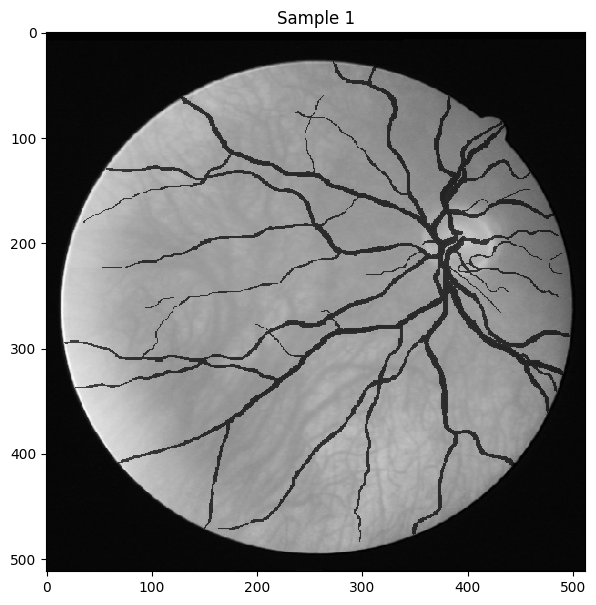

In [15]:
for i in range(1):
    visualize_vessel_sample(train_dataset[i], title=f"Sample {i+1}")

In [16]:
for batch_data in train_dataloader:
    print("Image shape:", batch_data["img"].shape)  # Expected: [batch_size, 1, 512, 512]
    break

Image shape: torch.Size([16, 1, 512, 512])


# Models

In [17]:
# Setting up the neural network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

The used device is cuda


In [18]:
models = build_ensemble_models(config, device)
print(f"Loaded {len(models)} models: {[type(m).__name__ for m in models]}")

Loaded 1 models: ['UNet']


# Training

In [19]:
import torch
import wandb
from tqdm import tqdm
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete
from regularization import *

import torch.nn.functional as F

def masked_loss(pred, target, valid_mask, criterion=create_loss(config)):##torch.nn.BCEWithLogitsLoss(reduction='none')):
    loss_map = criterion(pred, target)
    masked_loss = loss_map * valid_mask
    return masked_loss.sum() / valid_mask.sum()

def train(model, epochs, train_dataloader, validation_loader, optimizer,loss_function,n,early_stopping, device):
    dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
    post_pred = AsDiscrete(threshold=0.5)
    post_label = AsDiscrete(threshold=0.5)

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()    
        epoch_loss = 0.0
        step = 0

        for batch_data in train_dataloader:
            step += 1
            optimizer.zero_grad()

            imgs = batch_data["img"].float().to(device)
            masks = batch_data["mask"].float().to(device)
            if "valid_mask" in batch_data:
                valid_mask = batch_data["valid_mask"].float().to(device)
            else:
                valid_mask = torch.ones_like(batch_data["mask"]).float().to(device)

            preds = model(imgs)

            # Use masked loss
            loss = masked_loss(preds, masks, valid_mask)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss = epoch_loss / step
        print(f"Epoch [{epoch+1}/{epochs}], Avg Loss: {train_loss:.4f}")

        # ----- VALIDATION -----
        step = 0
        val_loss = 0
        correct_pixels = 0
        total_pixels = 0

        dice_metric.reset()
        model.eval()
        with torch.no_grad():
            for batch_data in validation_loader:
                step += 1

                imgs = batch_data["img"].float().to(device)
                masks = batch_data["mask"].float().to(device)

                if "valid_mask" in batch_data:
                    valid_mask = batch_data["valid_mask"].float().to(device)
                else:
                    valid_mask = torch.ones_like(masks).float().to(device)

                # Forward pass
                outputs = model(imgs)

                # Compute masked loss
                loss = masked_loss(outputs, masks, valid_mask)
                val_loss += loss.item()

                # Apply sigmoid and threshold
                preds = torch.sigmoid(outputs) > 0.5

                # Apply valid mask for accuracy and Dice
                masked_preds = preds.float() * valid_mask
                masked_targets = masks * valid_mask

                # Accuracy
                correct_pixels += (masked_preds == masked_targets).sum().item()
                total_pixels += valid_mask.sum().item()  # Count only valid pixels

                # Dice Score
                dice_metric(masked_preds, masked_targets)

            val_loss = val_loss / step
            accuracy = correct_pixels / total_pixels
            mean_dice = dice_metric.aggregate().item()
            dice_metric.reset()

            log_to_wandb(epoch, train_loss, val_loss, accuracy, mean_dice, batch_data, outputs)

            # Early stopping (if past warmup)
            if epoch >= 40:
                early_stopping(val_loss)
                if early_stopping.early_stop:
                    print("🛑 Early stopping triggered.")
                    break
                    
def log_to_wandb(epoch, train_loss, val_loss, accuracy, mean_dice, batch_data, outputs):
    """Logs metrics and image/mask visualizations to Weights & Biases."""
    
    imgs = batch_data['img'].detach().cpu()
    masks = batch_data['mask'].detach().cpu()
    preds = outputs.detach().cpu()

    # Optional valid_mask
    valid_mask = batch_data.get('valid_mask', None)
    if valid_mask is not None:
        valid_mask = valid_mask.detach().cpu()
    else:
        valid_mask = torch.ones_like(masks)  # fallback to all-valid

    log_imgs = []
    for img, pred, gt, vmask in zip(imgs, preds, masks, valid_mask):
        # Apply sigmoid to raw logits and binarize
        pred = torch.sigmoid(pred)
        pred_bin = torch.round(pred) * vmask  # apply valid mask
        gt_bin = gt * vmask

        # Log image with overlaid predictions and ground truth
        log_imgs.append(wandb.Image(img.squeeze(), masks=wandb_masks(pred_bin, gt_bin)))

    # Log everything
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'pixelaccuracy': accuracy,
        'mean_dice': mean_dice,
        'results': log_imgs
    })
    


def wandb_masks(mask_output, mask_gt):
    """Creates a dictionary of masks formatted for WandB image overlay."""
    class_labels = {1: 'vessels'}

    return {
        'predictions': {'mask_data': mask_output.squeeze().numpy(), 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt.squeeze().numpy(), 'class_labels': class_labels}
    }


In [21]:
def from_compose_to_list(transform):
    return transform.transforms

torch.manual_seed(42)
np.random.seed(42)
import random 
random.seed(42)

torch.cuda.empty_cache()

# defining the dictionary mapping each model to its Dice coefficient for l;ater computation
model_dice_dict = {}

for model in models:
    ##wandb.finish()  # ensures a clean slate

    print(f"Starting model: {model.__class__.__name__}")
    n = sum(p.numel() for p in model.parameters() if p.requires_grad) # number of parameters
    early_stopping = EarlyStopping(patience=config['early_stopping_patience'], delta=0.001)

    loss_function = create_loss(config)
    
    optimizer = create_optimizer(config, model)
    
    now = datetime.now()
    now_str = now.strftime("%Y-%m-%d_%H-%M-%S")
    print(now_str)

    run = wandb.init(
        project='DRIVE',
        name=now_str,
        config={
            #'models': str([type(m).__name__ for m in models]),
            'loss function': str(loss_function), 
            'lr': optimizer.param_groups[0]["lr"],
            'transform': from_compose_to_list(train_transforms),
            'batch_size': train_dataloader.batch_size,
            'layers': 5,
            'parameters': n,
            'early_stopping_patience': str(config['early_stopping_patience'])    
        }
    )
    wandb.config.update(config)
    run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

    ### training loop
    epochs = n_epochs
    train(model, epochs, train_dataloader, validation_loader, optimizer,loss_function,n,early_stopping, device)
    
    # Store the network parameters   
    os.makedirs(config['save_model'], exist_ok=True)
    torch.save(model.state_dict(), f"{config['save_model']}/{model.__class__.__name__}.pt")
    print(f"Model saved to {config['save_model']}")
    run.finish()
    
    api = wandb.Api()
    run = api.run(f"DRIVE/{run_id}")
    
    # Final Dice
    metric_fn = monai.metrics.DiceMetric()
    dice = compute_metric(validation_loader, model, metric_fn,device)
    run.summary["dice"] = dice
    run.summary.update()
    print(f"Dice on validation set: {dice:.3f}")

    model_dice_dict[model] = dice
    
    # Final Hausdorff distance
    metric_fn = monai.metrics.HausdorffDistanceMetric()
    HausdorffDistance = compute_metric(validation_loader, model, metric_fn,device)
    run.summary["HausdorffDistance"] = HausdorffDistance
    run.summary.update()
    print(f"HausdorffDistance on validation set: {HausdorffDistance:.3f}")

Starting model: UNet
2025-04-04_02-32-49


Epochs:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch [1/250], Avg Loss: 0.4327


Epochs:   0%|          | 1/250 [00:01<06:14,  1.50s/it]

Epoch [2/250], Avg Loss: 0.4680


Epochs:   1%|          | 2/250 [00:02<06:10,  1.49s/it]

Epoch [3/250], Avg Loss: 0.4488


Epochs:   1%|          | 3/250 [00:04<06:01,  1.46s/it]

Epoch [4/250], Avg Loss: 0.4485


Epochs:   2%|▏         | 4/250 [00:05<05:59,  1.46s/it]

Epoch [5/250], Avg Loss: 0.4445


Epochs:   2%|▏         | 5/250 [00:07<05:58,  1.46s/it]

Epoch [6/250], Avg Loss: 0.4427


Epochs:   2%|▏         | 6/250 [00:08<05:54,  1.45s/it]

Epoch [7/250], Avg Loss: 0.4397


Epochs:   3%|▎         | 7/250 [00:10<05:53,  1.46s/it]


KeyboardInterrupt: 

In [131]:
def evaluate_ensemble(models, val_loader, device):
    sigmoid = torch.nn.Sigmoid()
    threshold = 0.5
    dice_metric = monai.metrics.DiceMetric()

    for batch in val_loader:
        img = batch['img'].to(device)
        mask = batch['mask'].to(device)

        if img.dim() == 3:
            img = img.unsqueeze(0)

        # Ensemble prediction
        with torch.no_grad():
            preds = []
            for model in models:
                model.eval()
                out = model(img)
                probs = sigmoid(out)
                preds.append(probs.cpu())

            combined = torch.stack(preds).mean(dim=0)  # average strategy
            binarized = (combined > threshold).float().to(device)

        dice_metric(y_pred=binarized, y=mask)

    final_dice = dice_metric.aggregate().item()
    print(f"📊 Ensemble Dice Score: {final_dice:.4f}")
    
evaluate_ensemble(models, val_loader, device)


📊 Ensemble Dice Score: 0.6711


# Test

In [100]:
def visual_evaluation_nomask_ensemble(sample, models, device, method='average'):
    """
    Visual evaluation with ensemble:
    - Supports 'average' or 'vote' ensemble strategies.
    - Displays input and combined prediction overlay.
    """
    sigmoid = torch.nn.Sigmoid()
    threshold = monai.transforms.AsDiscrete(threshold_values=True)

    img_tensor = sample['img'].float().to(device)
    if img_tensor.dim() == 3:
        img_tensor = img_tensor.unsqueeze(0)  # [1, 1, H, W]

    # Collect outputs from all models
    with torch.no_grad():
        preds = []
        for model in models:
            model.eval()
            output = model(img_tensor)
            probs = sigmoid(output)  # Probabilities
            preds.append(probs.cpu())

        # Combine ensemble predictions
        if method == 'average':
            combined = torch.stack(preds).mean(dim=0)  # [1, 1, H, W]
        elif method == 'vote':
            binarized = [threshold(p) for p in preds]
            combined = torch.stack(binarized).float().mean(dim=0)
            combined = (combined > 0.5).float()
        else:
            raise ValueError(f"Unsupported ensemble method: {method}")

        combined_np = threshold(combined).squeeze().numpy()  # Final binarized mask

    # Get original image
    img_np = sample['img'].squeeze().cpu().numpy()

    combined_np = (combined.squeeze().cpu().numpy() > 0.5).astype(np.uint8)
    overlay_mask = np.ma.masked_where(combined_np == 0, np.ones_like(combined_np))

    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    ax[0].imshow(img_np, cmap='gray')
    ax[0].set_title('Input Image')

    ax[1].imshow(img_np, cmap='gray')
    # Try a bright colormap
    ax[1].imshow(overlay_mask, cmap='autumn', alpha=0.8, interpolation='none')
    ax[1].set_title("Prediction Overlay")

    plt.show()




Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 20.51it/s]


Test Image dtype: torch.float32
Test Image shape: torch.Size([1, 1, 512, 512])


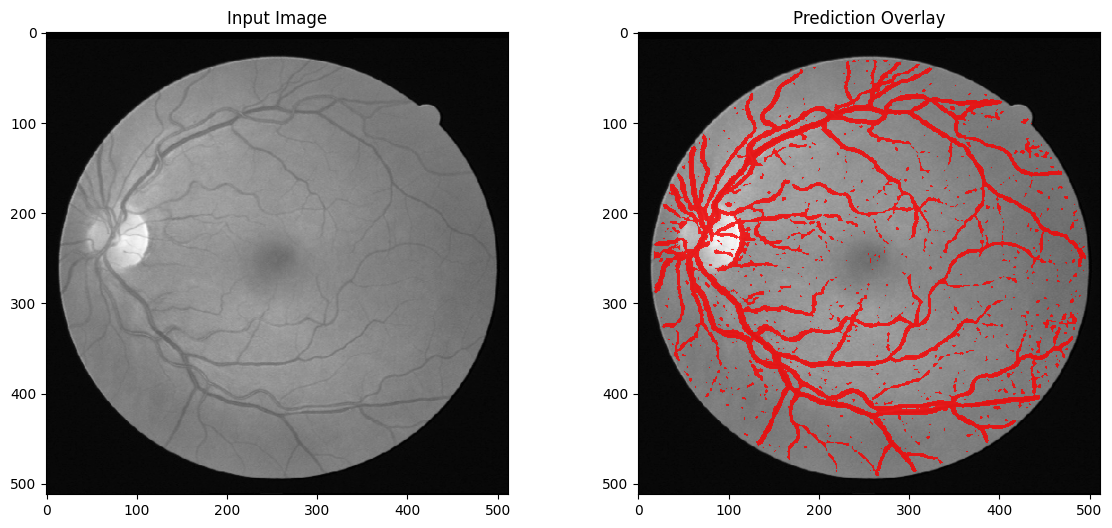

In [101]:
# Test dataset for now obtained from the training one (train_dict_list in monai.data.CacheDataset to obtain test_dataset) bacause the test dataset does not have useful masks
test_transform = monai.transforms.Compose([
    LoadVesselData(),  # ensures float32
    #monai.transforms.AddChanneld(keys=['img'])   #, 'mask']),
        #monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        #monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
    ###monai.transforms.EnsureTyped(keys=['img', 'mask'], dtype=torch.float32),  # Explicitly convert
])


test_dataset = monai.data.CacheDataset(test_dict_list, transform=test_transform)
test_loader = monai.data.DataLoader(test_dataset, batch_size=1)


for sample in test_loader:
    print("Test Image dtype:", sample["img"].dtype)  # Should be torch.float32
    #print("Test Mask dtype:", sample["mask"].dtype)  # Should be torch.float32
    print("Test Image shape:", sample["img"].shape)  # Should be [1, 1, 512, 512]
    break


for sample in test_loader:
    visual_evaluation_nomask_ensemble(sample, models,device)
    break

In [43]:
test_outputs = compute_test_predictions_weighted(test_loader, model_dice_dict, device)
print(f"Test set predictions computed for {len(test_outputs)} images")

Test set predictions computed for 20 images


# Export Predictions for the Grand-Challenge
https://drive.grand-challenge.org/evaluation/submissions/


In [136]:
models_for = config["ensemble_models"]
str_models = "___".join(models_for)

In [138]:
test_transform = Compose([
    LoadTestData(),  # Your MONAI-compatible test loader
])

save_outputs = '/'.join(config['save_model'].split('/')[:-1])  # e.g., '../saved_outputs'
os.makedirs(save_outputs, exist_ok=True)

save_path = f"{config['save_path']}_{str_models}"
zip_filename = f"{config['zip_filename']}_{str_models}.zip"
os.makedirs(save_path, exist_ok=True)

# 3. Ensemble Inference & Save Output Images
forced_size = (584, 565)  # original image shape
threshold_val = 0.5

print("🧠 Running ensemble prediction and saving masks...")
for i, sample in enumerate(tqdm(test_loader), 1):
    image = sample["img"].to(device)

    if image.dim() == 3:
        image = image.unsqueeze(0)  # [1, 1, H, W]

    with torch.no_grad():
        preds = []
        for m in models:
            m.eval()
            out = m(image)
            probs = torch.sigmoid(out)
            preds.append(probs.cpu())

        combined = torch.stack(preds).mean(dim=0)  # [1, 1, H, W]
        binary_mask = (combined > threshold_val).float()

    # Resize output mask to original shape
    resized_mask = F.interpolate(binary_mask, size=forced_size, mode='nearest')
    resized_mask_np = resized_mask.squeeze().cpu().numpy().astype(np.uint8) * 255

    # Save image
    filename = os.path.join(save_path, f"{i}.png")
    cv2.imwrite(filename, resized_mask_np)

print(f"✅ Saved all ensemble masks to: {save_path}")

# 4. Zip all saved images
print("📦 Creating zip archive...")
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in os.listdir(save_path):
        if file.endswith(".png"):
            zipf.write(os.path.join(save_path, file), arcname=file)

print(f"✅ Zip file created: {zip_filename}")

# 5. Optionally delete individual images
print("🧹 Cleaning up PNG files...")
for file in os.listdir(save_path):
    file_path = os.path.join(save_path, file)
    if file.endswith(".png") and os.path.isfile(file_path):
        os.remove(file_path)

os.rmdir(save_path)
print(f"✅ Cleaned up image files from: {save_path}")


🧠 Running ensemble prediction and saving masks...


100%|██████████| 20/20 [00:00<00:00, 24.75it/s]

✅ Saved all ensemble masks to: ../saved_outputs/output_images_vanilla_UNet___modified_UNet___dropout_UNet
📦 Creating zip archive...
✅ Zip file created: ../saved_outputs/segmentation_outputs_vanilla_UNet___modified_UNet___dropout_UNet.zip
🧹 Cleaning up PNG files...
✅ Cleaned up image files from: ../saved_outputs/output_images_vanilla_UNet___modified_UNet___dropout_UNet


## robe per grafici

Test Image dtype: torch.float32
Test Image shape: torch.Size([1, 1, 512, 512])


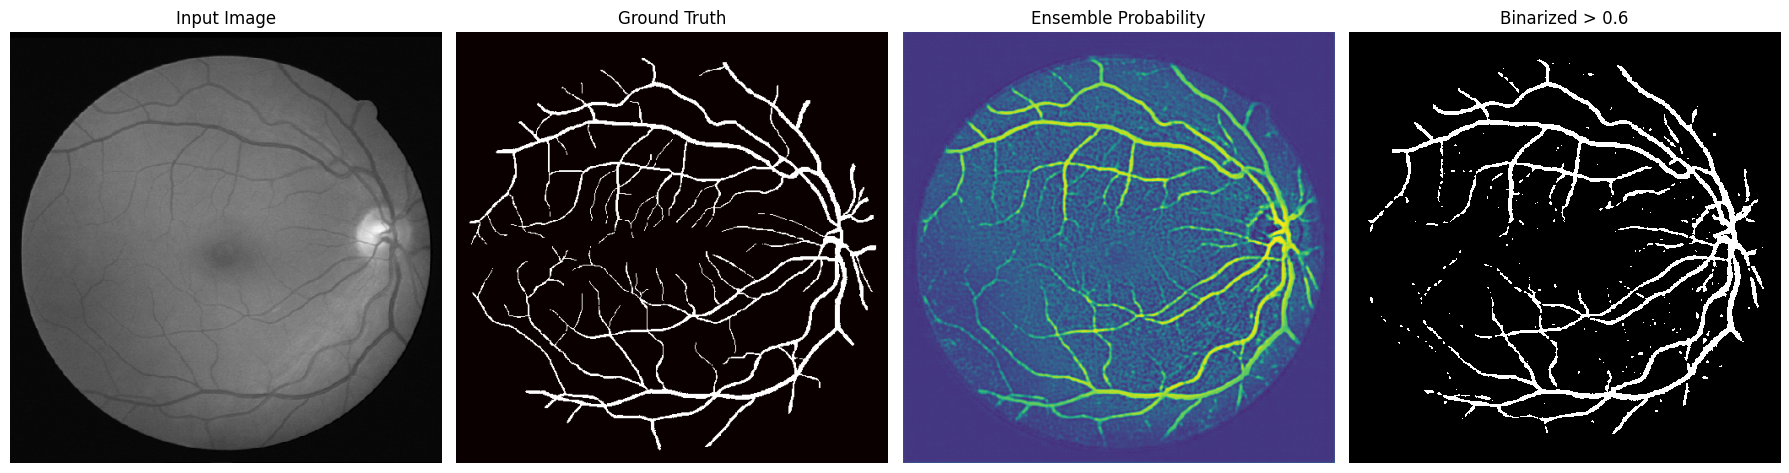

In [126]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import monai

def visual_evaluation_4panels_ensemble(sample, models, device, method='average', threshold_val=0.5):
    """
    Visual evaluation with an ensemble (4 subplots):
      1) Input image
      2) Ground truth (if present)
      3) Ensemble probability map
      4) Binarized ensemble output
    
    Args:
        sample (dict): A dictionary with keys at least "img". Optionally "mask" and "valid_mask".
        models (list): List of PyTorch models for the ensemble.
        device (torch.device): Where models are loaded (CPU/CUDA).
        method (str): 'average' or 'vote' for ensemble combination.
        threshold_val (float): Threshold to binarize probability map.
    """
    sigmoid = torch.nn.Sigmoid()
    threshold_monai = monai.transforms.AsDiscrete(threshold_values=True)

    # 1) Prepare input image
    img_tensor = sample["img"].float().to(device)
    if img_tensor.dim() == 3:
        # shape [1, H, W] → add batch dimension
        img_tensor = img_tensor.unsqueeze(0)  # [B=1, C=1, H, W]
    img_np = sample["img"].squeeze().cpu().numpy()  # for plotting

    # 2) Optional ground truth
    has_gt = ("mask" in sample)

    # 3) Ensemble inference
    with torch.no_grad():
        preds = []
        for model in models:
            model.eval()
            output = model(img_tensor)       # raw logits shape: [1, 1, H, W]
            probs = sigmoid(output)          # convert to probabilities
            preds.append(probs.cpu())

        # Combine ensemble predictions
        if method == 'average':
            # Soft probability average
            combined = torch.stack(preds).mean(dim=0)  # [1, 1, H, W]
        elif method == 'vote':
            # majority vote among binarized preds
            binarized = [threshold_monai(p) for p in preds]  # each is 0 or 1
            combined = torch.stack(binarized).float().mean(dim=0)
            # combined is in [0..1], e.g. 0.6 means 3 of 5 models said "1"
        else:
            raise ValueError(f"Unsupported ensemble method: {method}")

    # Convert to NumPy
    combined_probs_np = combined.squeeze().numpy()  # shape [H, W], values in [0..1]
    
    # 4) Optionally apply valid_mask
    if "valid_mask" in sample:
        valid = sample["valid_mask"].squeeze().cpu().numpy()
        combined_probs_np *= valid

    # 5) Binarize final ensemble
    combined_bin_np = (combined_probs_np > threshold_val).astype(np.uint8)

    # ----- Plotting -----
    fig, axes = plt.subplots(1, 4, figsize=(18, 5))

    # (A) Input Image
    axes[0].imshow(img_np, cmap='gray')
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # (B) Ground Truth (if present)
    if has_gt:
        gt_np = sample["mask"].squeeze().cpu().numpy()
        axes[1].imshow(gt_np, cmap='hot')
        axes[1].set_title("Ground Truth")
    else:
        axes[1].text(0.5, 0.5, "No GT Provided",
                     ha="center", va="center", fontsize=12)
    axes[1].axis("off")

    # (C) Ensemble Probability
    # show continuous [0..1] map
    axes[2].imshow(combined_probs_np, cmap='viridis')
    axes[2].set_title("Ensemble Probability")
    axes[2].axis("off")

    # (D) Binarized Ensemble
    axes[3].imshow(combined_bin_np, cmap='gray', interpolation='none')
    axes[3].set_title(f"Binarized > {threshold_val}")
    axes[3].axis("off")

    plt.tight_layout()
    plt.savefig("ensemble_4panel_sample.png", bbox_inches='tight', dpi=300)

    plt.show()

val_loader = monai.data.DataLoader(val_dataset, batch_size=1)


for sample in val_loader:
    print("Test Image dtype:", sample["img"].dtype)  # Should be torch.float32
    #print("Test Mask dtype:", sample["mask"].dtype)  # Should be torch.float32
    print("Test Image shape:", sample["img"].shape)  # Should be [1, 1, 512, 512]
    break
    
for sample in val_loader:
    visual_evaluation_4panels_ensemble(sample, models, device, method='average', threshold_val=0.6)
    break

